# Bagging ensemble to stablize estimation
This notebook is similar to LearnUSA_applyCanada.ipynb. Only difference is using bagging (an abreviation of “bootstrap aggregation”) ensembles to stablize its estimation. Its basic algorithm is explained in the following links.

https://blog.statsbot.co/ensemble-learning-d1dcd548e936

https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/


## import libraries
Before running this, please install pyMAGIQ using setup.py.
> python setup.py install

In [1]:
# r_seed = 119 # 119 is a good example
r_seed = 122 # 121 and 122 are good examples

import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(r_seed)
rn.seed(r_seed)
tf.set_random_seed(r_seed)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import csv
import sys
import json
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense,Activation, Flatten
from keras.optimizers import RMSprop
from keras.optimizers import Adamax
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.models import model_from_json
from keras.utils import plot_model
from keras.utils import np_utils
from keras import initializers

# Local Import
import pyMAGIQ


/Users/nimamura/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# global variables
### frequency for basic USArray
from shorter period to longer period

In [2]:
freq_interp = [  1.367187E-01, 1.093750E-01, 8.593753E-02, 6.640627E-02, 5.078124E-02, 3.906250E-02,
        3.027344E-02, 2.343750E-02, 1.855469E-02, 1.464844E-02, 1.171875E-02, 9.765625E-03,
        7.568361E-03, 5.859374E-03, 4.638671E-03, 3.662109E-03, 2.929688E-03, 2.441406E-03,
        1.892090E-03, 1.464844E-03, 1.159668E-03, 9.155271E-04, 7.324221E-04, 6.103516E-04,
        4.425049E-04, 3.204346E-04, 2.136230E-04, 1.373291E-04, 8.392331E-05, 5.340577E-05]

## parameter of neural network
* nunits: number of nodes for each
* nrate : number of rating for impedance tensor
* nfreq : number of frequencies for inputs
* ndata : number of data used for impecance tensor (Apparent resistivities, phases and those errorbar)
* ncomp : number of components used for impecance tensor (xy and yx)
* epochs : number of iterations
* batch_size : number of samples that going to be propagated through the network.

In [3]:
# nunits = 10
nunits = 40
# nunits = 100

nrate = 5
nfreq = 30
ndata = 4
ncomp = 2
epochs = 1000
batch_size = 32

# number of bagging
rounds = 1
# rounds = 5


## Loading the data

Raw files downloaded from:
- http://ds.iris.edu/spud/emtf

and saved training data in ~/GIC/survey/ZML/data/train, test data in ~/GIC/survey/ZML/data/test. Test data is used for the validation, so training and test data have to have rating information in xml file. Please save unrated data in ~/GIC/survey/ZML/data/unrated. Unrated data does not have rating information in xml file.

In [9]:
# Set directory to read impedance tensor in xml data format

# Set the file paths appropriately for your own situation
# datadir = '/Users/nimamura/GIC/survey/ZML/data_paper'
datadir = '/Users/nimamura/Library/Mobile Documents/com~apple~CloudDocs/pyMAGIQ/pyMAGIQ/survey/USArray2019March'
# datadir = '/Users/nimamura/GIC/survey/ZML/data'
# datadir = '/home/nimamura/GIC/survey/ZML/data'
# datadir = '/home/server/pi/homes/nimamuara/GIC/survey/ZML/data'

traindir    = datadir + '/train'
testdir     = datadir + '/test'
X_trainpath = datadir + '/X_train.csv'
X_testpath  = datadir + '/X_test.csv'
y_trainpath = datadir + '/y_train.csv'
y_testpath  = datadir + '/y_test.csv'
rate_trainpath  = datadir + '/rate_train.csv'
rate_testpath  = datadir + '/rate_test.csv'
SiteIDpath  = datadir + '/siteID_train.csv'


In [14]:
# list in training directory and test directory
trainlists = sorted( [f for f in os.listdir(traindir) if not f.startswith('.')] )
testlists  = sorted( [f for f in os.listdir(testdir) if not f.startswith('.')] )

# number of lists
nMTtrain = len(trainlists)
nMTtest  = len(testlists)

## Reading and saving data
* X_train : impedance tensor of training datasets
* y_train : rating of training datasets
* X_test  : impedance tensor of test datasets
* y_test  : rating of test datasets


In [15]:
# read X and y data from xml file
# read X_train and y_train
X_train = np.zeros((nMTtrain,nfreq,ndata*ncomp*2),dtype=np.float32)    # Note that real value
y_train = np.zeros((nMTtrain,),dtype=np.int)

X_train, y_train, rate_train, SiteID_train, xml_train = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getXYdataset(X_train,y_train,nfreq,traindir,trainlists,freq_interp)

# read X_test and y_test
# X_test = np.zeros((nMTtest,nfreq,ndata*ncomp),dtype=np.float32)    # Note that real value
# y_test = np.zeros((nMTtest,),dtype=np.int)

# X_test, y_test, rate_test, xml_dict = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getXYdataset(X_test,y_test,nfreq,testdir,testlists,freq_interp)

# change shape to fit it to deep learning
X_train = X_train.reshape(len(X_train),nfreq*ndata*ncomp*2).astype('float32')
# X_test  = X_test.reshape(len(X_test),nfreq*ndata*ncomp).astype('float32')

# save X and y data in csv format. You don't have to read EDI files again
# np.savetxt( X_trainpath, X_train, fmt="%.5e", delimiter=',')
# np.savetxt( X_testpath,  X_test, fmt="%.5e", delimiter=',')
np.savetxt( X_trainpath, X_train, delimiter=',')
# np.savetxt( X_testpath,  X_test, delimiter=',')
np.savetxt( y_trainpath, y_train, fmt='%d', delimiter=',')
# np.savetxt( y_testpath,  y_test, fmt='%d', delimiter=',')
np.savetxt( rate_trainpath, rate_train, fmt='%d', delimiter=',')
# np.savetxt( rate_testpath,  rate_test, fmt='%d', delimiter=',')

with open(SiteIDpath,'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in SiteID_train:
        writer.writerow([val])


MT_TF_USArray.ALW48.2015
reading Z.INVSIGCOV
MT_TF_USArray.ALW49.2015
reading Z.INVSIGCOV
MT_TF_USArray.ALX50.2015
reading Z.INVSIGCOV
MT_TF_USArray.ALY50.2015
reading Z.INVSIGCOV
MT_TF_USArray.ALZ51.2015
reading Z.INVSIGCOV
MT_TF_USArray.ARU43.2014
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
MT_TF_USArray.CAM01.2007
reading Z.INVSIGCOV
MT_TF_USArray.CAM02.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAM03.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAM04.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAM05.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAM06.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAM94.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN01.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN02.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN03.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN03.2011
reading Z.INVSIGCOV
MT_TF_USArray.CAN04.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN05.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAN06.2010
reading Z.INVSIGCOV
MT_TF_USArray.CAO01.2010


## histogram of rate

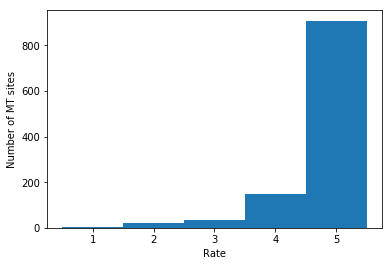

In [16]:
pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.ratehistogram1d(rate_train,fname='rate_hist.eps')

In [19]:
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, nrate)
# y_test  = np_utils.to_categorical(y_test, nrate)


## Canadian dataset information
Setup directory first

In [9]:
unrateddir       = datadir + '/unrated'
X_unratedpath    = datadir + '/X_unrated.csv'
y_unratedpath    = datadir + '/y_unrated.csv'
rate_unratedpath = datadir + '/rate_unrated.csv'
SiteIDpath_unrated = datadir + '/siteID_unrated.csv'

unratedlists = sorted( [f for f in os.listdir(unrateddir) if not f.startswith('.')] )

nMTunrated  = len(unratedlists)


## read X_unrated
Reading Canadian impedance matrix datasets

In [10]:
# read X_unrated
X_unrated = np.zeros((nMTunrated,nfreq,ndata*ncomp*2),dtype=np.float32)    # Note that real value
X_unrated,SiteID_unrated, xml_unrated = pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getX_unrated(X_unrated,nfreq,unrateddir,unratedlists,freq_interp)

# convert shape
X_unrated = X_unrated.reshape(len(X_unrated),nfreq*ndata*ncomp*2).astype('float32')

# set y_vote for voting
y_vote = np.zeros( (len(X_unrated),nrate), dtype=np.float )

# save X and y data in csv format. You don't have to read EDI files again
np.savetxt( X_unratedpath,  X_unrated, delimiter=',')
with open(SiteIDpath_unrated,'w') as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in SiteID_unrated:
        writer.writerow([val])

MT_TF_CAFE-MT.CAF02.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
55188.21
MT_TF_CAFE-MT.CAF04.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
55188.21
MT_TF_CAFE-MT.CAF06.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
43690.67
MT_TF_CAFE-MT.CAF09.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
55188.21
MT_TF_CAFE-MT.CAF11.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
55188.21
MT_TF_CAFE-MT.CAF13.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
skip it! IndexError when reading XML file  MT_TF_CAFE-MT.CAF13.2010
MT_TF_CAFE-MT.CAF15.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV
55188.21
MT_TF_CAFE-MT.CAF18.2010
Use Hx orient

## Now create deep learning model

In [20]:
def neuralnet():
    # add layers
#     reg_val = 0.0001
#     reg_ker = 0.004

#     reg_val = 0.00001
#     reg_ker = 0.0002

    reg_val = 0.00001
    reg_ker = 0.0003

#     reg_val = 0.00001
#     reg_ker = 0.0004
    
#     reg_val = 0.00002
#     reg_ker = 0.0005

#     reg_val = 0.0001
#     reg_ker = 0.002


#     reg_val = 0.0001
#     reg_ker = 0.002
#     reg_val = 0.0001
#     reg_ker = 0.001
    
    initializers.Initializer()
    initializers.RandomNormal(seed=r_seed)
    
    # initialize model
    model = Sequential()

    # add layers
    model.add(Dense( activation='relu', units=nunits,
                     kernel_regularizer=regularizers.l1(reg_ker),
                     input_dim=ndata*ncomp*nfreq*2))


    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='relu',
                     kernel_regularizer=regularizers.l1(reg_val),
                     units=nunits ))

    model.add(Dense( activation='softmax', units=nrate,
                     kernel_regularizer=regularizers.l1(reg_ker),
                     name='preds' ))

    return model


## functions used for bagging

In [21]:
def randomXY(X, y):
    
    X_r = np.zeros(X.shape)
    y_r = np.zeros(y.shape)

    randindex = np.random.randint(len(X),size=len(X))

    X_r = X_train[randindex,:]
    y_r = y_train[randindex,:]
#     print(randindex)

    return X_r,y_r,randindex



## Optimization for each bags

In [22]:
for ibag in range(rounds):
    # fixing random seed
    import numpy as np
    import tensorflow as tf
    import random as rn

    import os
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(r_seed+ibag)
    rn.seed(r_seed)
    tf.set_random_seed(r_seed)

    session_conf = tf.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    from keras import backend as K
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

    from keras.models import Sequential
    from keras.layers import Dense,Activation, Flatten
    from keras.optimizers import RMSprop
    from keras.optimizers import Adamax
    from keras.callbacks import ModelCheckpoint
    from keras import regularizers
    from keras.models import model_from_json
    from keras.utils import plot_model
    from keras.utils import np_utils
    from keras import initializers
    
    # make input X and y 
#     X_r = X_train
#     y_r = y_train
    X_r,y_r,randindex = randomXY(X_train,y_train)
    
    # read model
    model = neuralnet()

    # setting optimization
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adamax(),
                  metrics=["accuracy"])

    model.summary()
    # learning parameters
    history = model.fit(X_r, y_r, epochs=epochs,
                        validation_split=0.1, batch_size=batch_size)
    val_acc = max(history.history['val_acc'])

    #evaluate unrated
    y_est = model.predict(X_unrated)
#     print(model.get_weights())
    
    # convert y_est to integer form
    y_int = np.argmax(y_est,axis=1)
    # change it to binary form
    y_bin = np_utils.to_categorical(y_int, nrate)

    # save y_bin to y_vote
    y_vote += y_bin



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                19240     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
__________

NameError: name 'X_unrated' is not defined

## Voting time

In [ ]:
# start voting
y_pred = np.argmax(y_vote,axis=1)

# write to file
y_votepath = datadir + '/y_vote.csv'
y_predpath = datadir + '/y_pred.csv'

np.savetxt( y_votepath, y_vote, fmt='%d', delimiter=',')
np.savetxt( y_predpath, y_pred, fmt='%d', delimiter=',')


NameError: name 'y_pred' is not defined

## Save model and data 
Note that the last bagging model is saved

In [15]:
# plot_model returns error when using python 3, so commented out.
# save model in png file
#plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

# save model
model_json = model.to_json()
with open("model.json",mode='w') as f:
    f.write(model_json)
    
# save weight
model.save_weights('weights.hdf5')


## Human rating vs AI rating

In [16]:
# take validation model and rate
ndata_val = int(len(X_r)*0.1)
Xval = X_r[-ndata_val:-1,:]
yval = y_r[-ndata_val:-1]
index_val = randindex[-ndata_val:-1]

# read model
model = model_from_json(open('model.json').read())

# read weights
model.load_weights('weights.hdf5')

model.summary()

# setting optimization
model.compile(loss="categorical_crossentropy",
              optimizer=Adamax(),
              metrics=["accuracy"])

#evaluate unrated
yval_est  = model.predict(Xval)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                19240     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
__________

[[ 1  0  1  0  0]
 [ 0  1  0  0  0]
 [ 0  2  8  2  0]
 [ 0  0  7 22  3]
 [ 0  0  0 21 30]]


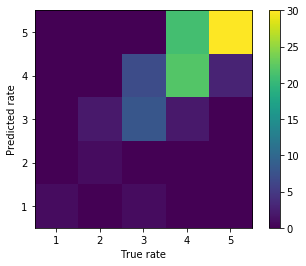

In [17]:
pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.ratehistogram2d(yval_est,yval,5,fname='hist2d.eps')

## read model and apply it to X_unrated

In [18]:
# # read model
# model = model_from_json(open('model.json').read())

# # read weights
# model.load_weights('weights.hdf5')

# model.summary()

# # setting optimization
# model.compile(loss="categorical_crossentropy",
#               optimizer=Adamax(),
#               metrics=["accuracy"])

# #evaluate unrated
# y_est  = model.predict(X_unrated)

# np.savetxt( y_unratedpath, y_est, delimiter=',' )


## Plot convergence history

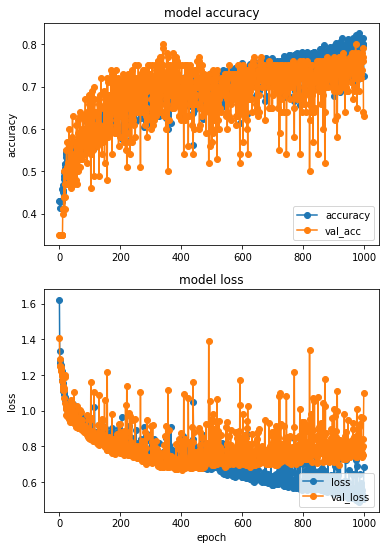

In [19]:
# plot history of convergence
pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.plot_history(history)

In [20]:
max(history.history['val_acc'])
# max(history.history['acc'])

# history.history['val_acc'][-1]
# history.history['acc'][-1]



0.8

## Reading saved weights.hdf5

In [21]:
# import h5py

# # inverse of freq_interp
# period = [ 1.0/x for x in freq_interp ]

# filename = '/Users/nimamura/GIC/pyMAGIQ/notebook/weights.hdf5'
# f = h5py.File(filename, 'r')
# # List all groups
# dense1 = f['dense_9']['dense_9']
# # dense1 = f['dense_73']['dense_73']
# # dense1 = f['dense_33']['dense_33']

# bias   = dense1['bias:0']
# kernel = dense1['kernel:0']
# # convert h5py dataset to ndarray
# dset = kernel[()]

# nnode = len(dset[0])

# Wmatrix = np.zeros( (ncomp*ndata,nfreq,nnode) ,dtype=np.float32)
# for inode in range(nnode):
#     tmp = dset[:,inode]
#     Wmatrix[:,:,inode] = tmp.reshape(ncomp*ndata,nfreq,order='F')


## Plot Wmatrix

In [22]:
# def plot_line_dset(Wmatrix):

#     nnode = Wmatrix.shape[2]

#     plt.figure(figsize=(18,12))

#     for i in range(8):
#         if i%2 == 0:
#             comp = '(xy)'
#         else:
#             comp = '(yx)'

#         if i//2 == 0:
#             data = 'Apparent resistivity'
#         elif i//2 == 1:
#             data = 'Phase'
#         elif i//2 == 2:
#             data = 'Error bar of apparent resistivity'
#         elif i//2 == 3:
#             data = 'Error bar of phase'

#         plt.subplot(2,4,i+1)
#         string = data + ' ' + comp
#         plt.title(string)
#         for inode in range(nnode):
#             W = np.log10( np.abs( Wmatrix[i,:,inode] ) )
#             plt.semilogx(period,W,'k-o')
#             plt.xlabel('Period (sec)')

#     plt.savefig('./cnn_group.eps',format='eps')
#     plt.show()

# plot_line_dset(Wmatrix)


## Plot rated Map US
define function first

In [23]:
from mpl_toolkits.basemap import Basemap
import xml.etree.ElementTree as ET

#************************************************************************/
def read_rate(path):

    ratelist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            maxindex = np.argmax(row) + 1
            ratelist.append( maxindex )

    return ratelist

#************************************************************************/
def read_rate_ytrain(path):

    ratelist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            ratelist.append( int(row[0])+1 )

    return ratelist

#************************************************************************/
def read_siteID(path):

    siteIDlist = []

    with open(path,'r') as f:
        reader = csv.reader(f)

        for row in reader:
            siteIDlist.append(row[0])

    return siteIDlist

#************************************************************************/
def plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist,fname):

    sc = 12

    fig = plt.figure(figsize=(16,9), dpi=150, facecolor='w', edgecolor='k')

    # Map
    m = Basemap(projection='merc',
                     resolution='l',
                     llcrnrlon=xmin,
                     llcrnrlat=ymin,
                     urcrnrlon=xmax,
                     urcrnrlat=ymax)

    m.drawcoastlines(color='lightgray')
    m.drawcountries(color='lightgray')
    m.fillcontinents(color='white', lake_color='#eeeeee', zorder = 0);
    m.drawmapboundary(fill_color='#eeeeee')

    cm = plt.cm.get_cmap('rainbow',5)
    x,y = m(lonlist, latlist)
    sca= m.scatter(x,y,c=ratelist, s=sc,cmap=cm)

    plt.colorbar(sca, shrink=0.6)
    plt.clim(0.5,5.5)
    fig.savefig('./'+fname,format='eps')
    plt.show()


In [18]:
target='train'

xmin = -140
xmax = -65.0
ymin = 28.0
ymax = 50.0

latlist = []
lonlist = []

# read rate
ratelist = read_rate_ytrain(y_trainpath)

# read site ID
siteIDlist = read_siteID(SiteIDpath)

for i in range(len(xml_train)):
    latlist.append(xml_train[i]['lat'])
    lonlist.append(xml_train[i]['lon'])

# latlist,lonlist = read_lonlat(datadir,siteIDlist,target)
fname = 'imageUS.eps'
plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist,fname)


NameError: name 'read_rate_ytrain' is not defined

## Plot rated Map Canada

/Users/nimamura/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/nimamura/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


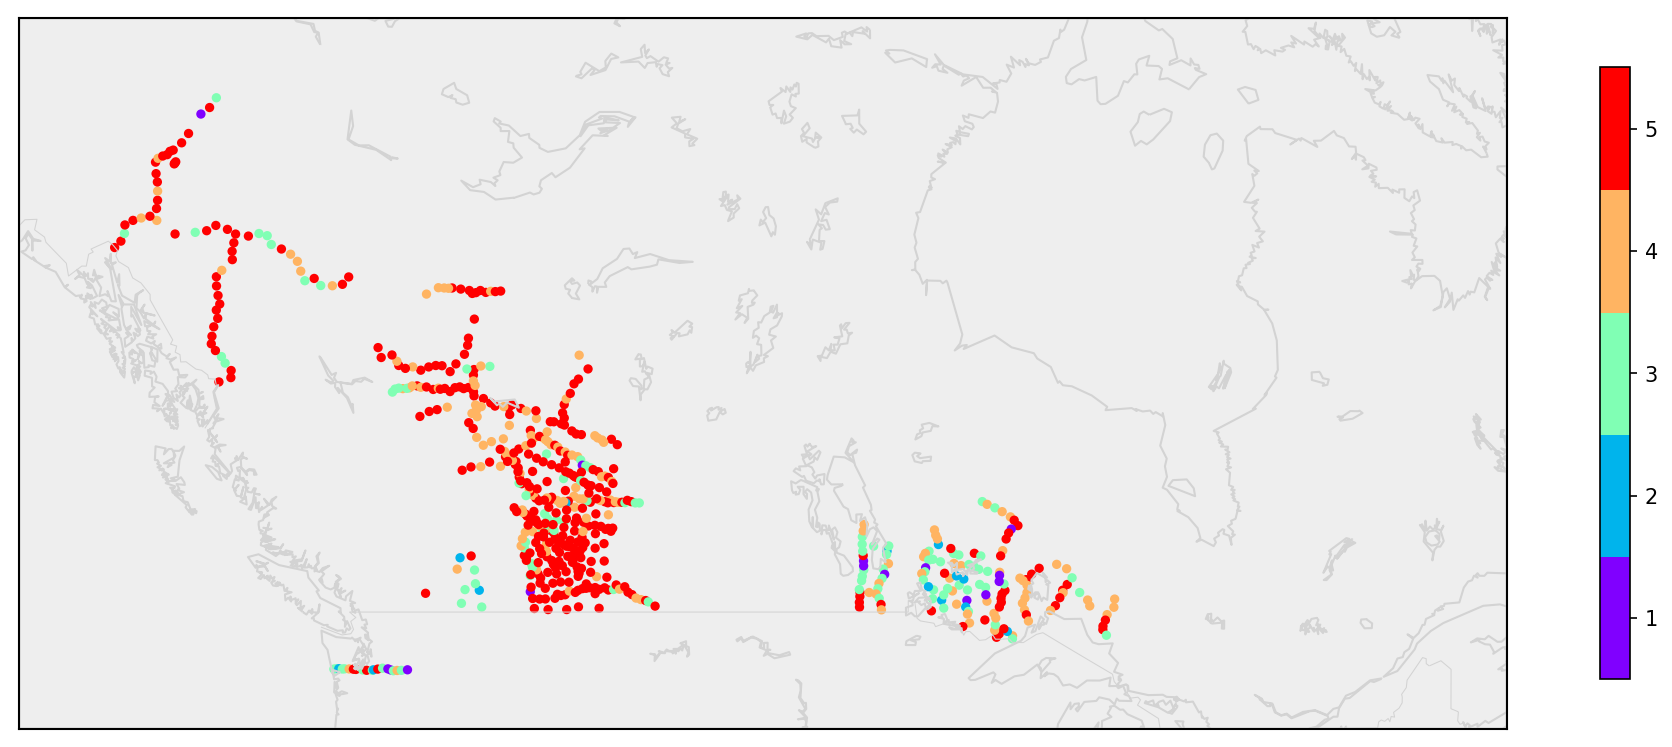

In [25]:
target = 'unrated'

xmin = -140
xmax = -65.0
ymin = 45.0
ymax = 65.0

latlist = []
lonlist = []


# read rate
# ratelist = read_rate(y_unratedpath)
ratelist = read_rate_ytrain(y_predpath)

# read site ID
siteIDlist = read_siteID(SiteIDpath_unrated)

for i in range(len(xml_unrated)):
    latlist.append(xml_unrated[i]['lat'])
    lonlist.append(xml_unrated[i]['lon'])

fname = 'imageCanada.eps'
plotMap(datadir,xmin,xmax,ymin,ymax,latlist,lonlist,ratelist,fname)



In [26]:
for i in range(1,6):
    print(i, ' number of index ',ratelist.count(i))
# ratelist.index(3)

1  number of index  15
2  number of index  13
3  number of index  102
4  number of index  150
5  number of index  346


## Check estimated Apparent resistivity using unrated datasets
define function first

In [27]:
import matplotlib.gridspec as gridspec

#************************************************************************/
def plot_Z(alldata,targetSiteID,fname='AppRes.eps'):

    fig = plt.figure(figsize=(14,12))
    outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)

    for i in range(9):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        # target Site ID name
        target = targetSiteID[i]

        # read variable
        Zapp_xy     = alldata[target]['Zapp_xy']
        Zapp_err_xy = alldata[target]['Zapp_err_xy']
        Zphs_xy     = alldata[target]['Zphs_xy']
        Zphs_err_xy = alldata[target]['Zphs_err_xy']

        Zapp_yx     = alldata[target]['Zapp_yx']
        Zapp_err_yx = alldata[target]['Zapp_err_yx']
        Zphs_yx     = alldata[target]['Zphs_yx']
        Zphs_err_yx = alldata[target]['Zphs_err_yx']

        period      = alldata[target]['period']
        prate       = alldata[target]['prate']
        if 'grate' in alldata[target].keys():
            grate   = alldata[target]['grate']
            title_str = 'Pred Rate: ' + str(prate) + '  Given Rate: ' + str(grate)
        else:
            title_str = 'Pred Rate: ' + str(prate)


        for j in range(2):
            ax = plt.Subplot(fig, inner[j])
            ax.grid()
            if j == 0:
                ax.set_title(title_str)
                ax.errorbar(period,Zapp_xy,yerr=Zapp_err_xy,fmt='o',mfc='none',capsize=4,label='xy')
                ax.errorbar(period,Zphs_yx,yerr=Zphs_err_yx,fmt='o',mfc='none',capsize=4,label='yx',c='r')
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim([1.E-0,1.E+5])
                plt.setp(ax.get_xticklabels(), visible=False)
                if i ==0 or i==3 or i== 6:
                    ax.set_ylabel("App. Res.")

            else:
                ax.errorbar(period,Zphs_xy,yerr=Zphs_err_xy,fmt='o',mfc='none',capsize=4)
                ax.errorbar(period,Zphs_yx,yerr=Zphs_err_yx,fmt='o',mfc='none',capsize=4,c='r')
                ax.set_xscale('log')
                ax.set_xlim([1.E-0,1.E+5])
                ax.set_ylim([0,90])
                ax.set_yticks([0,30,60,90])
                if i ==0 or i==3 or i== 6:
                    ax.set_ylabel("Phase")
                
                if i >5:
                    ax.set_xlabel("Period (sec)")
                # ax.grid()

            fig.add_subplot(ax)

    plt.savefig('./' + fname,format='eps')
    plt.show()

MT_TF_Lithoprobe.SNO323.1999
Use Hx orientation as a declination angle, instead of original declination
reading Z.VAR
MT_TF_UofAlberta.sa175.2010
reading Z.VAR
MT_TF_Lithoprobe.WST139.1998
reading Z.VAR
MT_TF_Lithoprobe.ABT310.1993-1996
reading Z.VAR
MT_TF_Lithoprobe.ABT301.1993-1996
reading Z.VAR
MT_TF_Lithoprobe.ABT006.1993-1996
reading Z.VAR
MT_TF_UofAlberta.bc310.2009
reading Z.VAR
MT_TF_Lithoprobe.WST004.1998
reading Z.VAR
MT_TF_CAFE-MT.CAF11.2010
Use Hx orientation as a declination angle, instead of original declination
reading Z.INVSIGCOV


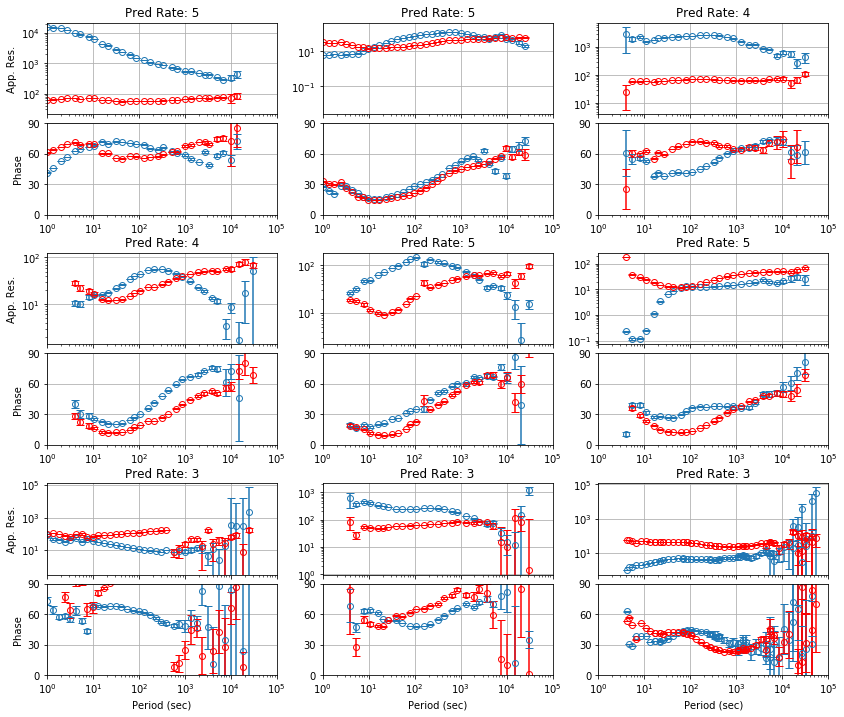

In [28]:
# ID list to plot
# Change this list as you like
targetSiteID_unrated = ['MT_TF_Lithoprobe.SNO323.1999',
                'MT_TF_UofAlberta.sa175.2010',
                'MT_TF_Lithoprobe.WST139.1998',
                'MT_TF_Lithoprobe.ABT310.1993-1996',
                'MT_TF_Lithoprobe.ABT301.1993-1996',
                'MT_TF_Lithoprobe.ABT006.1993-1996',
                'MT_TF_UofAlberta.bc310.2009',
                'MT_TF_Lithoprobe.WST004.1998',
                'MT_TF_CAFE-MT.CAF11.2010' ]

target = 'unrated'

alldata = {}

# read rate
# ratelist = read_rate(y_unratedpath)
ratelist = read_rate_ytrain(y_predpath)

# change variable name
targetSiteID = targetSiteID_unrated

siteIDlist = read_siteID(SiteIDpath_unrated)

for i in range(len(targetSiteID)):
    print( targetSiteID[i] )
    # initialize dictionary for current MT site
    alldata[targetSiteID[i]] = {}
    siteIndex = siteIDlist.index( targetSiteID[i] )

    MTdir = datadir + '/' + target + '/' + targetSiteID[i]

    # filename of xml
    XMLlist = sorted( [f for f in os.listdir(MTdir) if f.endswith('xml')] )

    # path to xml and edi file
    XMLpath = MTdir + '/' + XMLlist[0]

    period, xmldata, Zapp, Zapp_err, Zphs, Zphs_err, _ = pyMAGIQ.gicpy.iofiles.io.readXML(XMLpath,True)

    prate = ratelist[siteIndex]

    Zapp2 = Zapp[:,1:2].flatten().tolist()
    Zapp_err2 = Zapp_err[:,1:2].flatten().tolist()
    Zphs2 = Zphs[:,1:2].flatten().tolist()
    Zphs_err2 = Zphs_err[:,1:2].flatten().tolist()

    Zapp3 = Zapp[:,2:3].flatten().tolist()
    Zapp_err3 = Zapp_err[:,2:3].flatten().tolist()
    Zphs3 = Zphs[:,2:3].flatten().tolist()
    Zphs_err3 = Zphs_err[:,2:3].flatten().tolist()

    alldata[targetSiteID[i]]['Zapp_xy']     = Zapp2
    alldata[targetSiteID[i]]['Zapp_err_xy'] = Zapp_err2
    alldata[targetSiteID[i]]['Zphs_xy']     = Zphs2
    alldata[targetSiteID[i]]['Zphs_err_xy'] = Zphs_err2

    alldata[targetSiteID[i]]['Zapp_yx']     = Zapp3
    alldata[targetSiteID[i]]['Zapp_err_yx'] = Zapp_err3
    alldata[targetSiteID[i]]['Zphs_yx']     = Zphs3
    alldata[targetSiteID[i]]['Zphs_err_yx'] = Zphs_err3

    alldata[targetSiteID[i]]['period']      = period
    alldata[targetSiteID[i]]['prate']       = prate

plot_Z(alldata,targetSiteID)


## rate 4 vs 5

In [29]:
# n = 90
# grate = yval[0:n]
# prate  = yval_est[0:n]
# SiteIDs = index_val[0:n]

# for i in range(n):
#     grate = yval[i]
#     prate = yval_est[i]
#     ind   = SiteIDs[i]
#     print(i,grate,prate,SiteID_train[ind])


MT_TF_USArray.WYK19.2009
reading Z.INVSIGCOV
4 3
MT_TF_USArray.KYT47.2014
reading Z.INVSIGCOV
5 5
MT_TF_USArray.PAK58.2016
reading Z.INVSIGCOV
1 1
MT_TF_USArray.DEM59.2016
reading Z.INVSIGCOV
4 3
MT_TF_USArray.IAM36.2012
reading Z.INVSIGCOV
5 4
MT_TF_USArray.RES54.2016
reading Z.INVSIGCOV
2 2
MT_TF_USArray.REL59.2016
reading Z.INVSIGCOV
3 3
MT_TF_USArray.IDA11.2007
reading Z.INVSIGCOV
4 4
MT_TF_USArray.WYYS1.2009
reading Z.INVSIGCOV
3 3


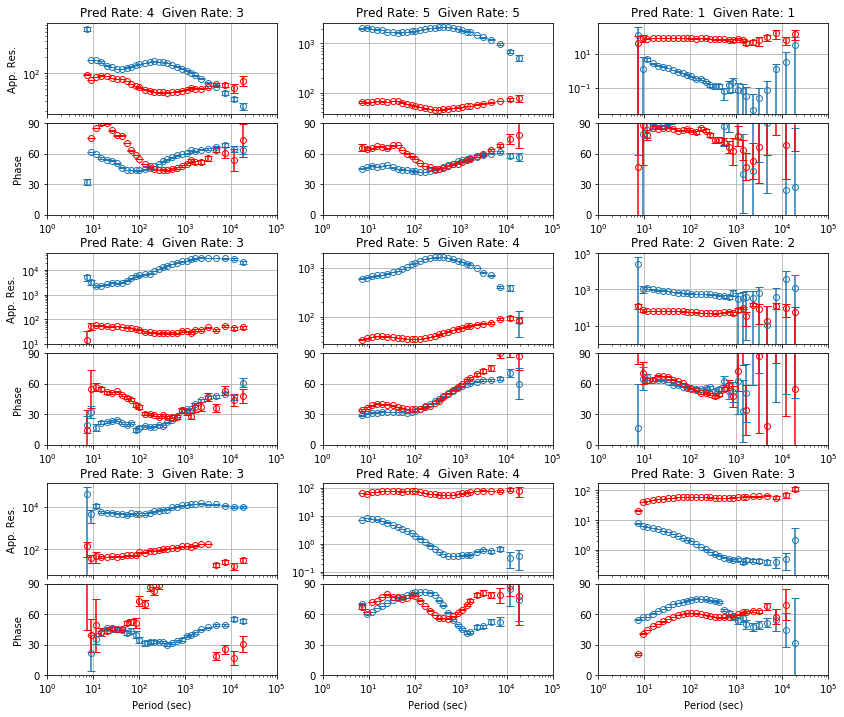

In [30]:
pickup_index = [2, 4, 23, 96, 32, 25, 78, 79, 86]
# pickup_index = [0, 1, 67, 24, 25, 90, 84, 29, 86]   # for rseed 199
# pickup_index = [11, 3, 13, 4, 5, 27, 86, 21, 38]


target = 'train'
targetSiteID = []
alldata = {}
for i in range(len(pickup_index)):
    targetindex = pickup_index[i]
    SiteID = SiteID_train[index_val[targetindex]]
    
    print(SiteID)
    targetSiteID.append( SiteID )
    grate = np.argmax( yval[targetindex] ) + 1
    prate = np.argmax( yval_est[targetindex] ) + 1
    
    alldata[targetSiteID[i]] = {}

    MTdir = datadir + '/' + target + '/' + targetSiteID[i]

    # filename of xml
    XMLlist = sorted( [f for f in os.listdir(MTdir) if f.endswith('xml')] )

    # path to xml and edi file
    XMLpath = MTdir + '/' + XMLlist[0]

    period, xmldata, Zapp, Zapp_err, Zphs, Zphs_err, _ = pyMAGIQ.gicpy.iofiles.io.readXML(XMLpath,Rotate=True)

    Zapp2 = Zapp[:,1:2].flatten().tolist()
    Zapp_err2 = Zapp_err[:,1:2].flatten().tolist()
    Zphs2 = Zphs[:,1:2].flatten().tolist()
    Zphs_err2 = Zphs_err[:,1:2].flatten().tolist()

    Zapp3 = Zapp[:,2:3].flatten().tolist()
    Zapp_err3 = Zapp_err[:,2:3].flatten().tolist()
    Zphs3 = Zphs[:,2:3].flatten().tolist()
    Zphs_err3 = Zphs_err[:,2:3].flatten().tolist()

    alldata[targetSiteID[i]]['Zapp_xy']     = Zapp2
    alldata[targetSiteID[i]]['Zapp_err_xy'] = Zapp_err2
    alldata[targetSiteID[i]]['Zphs_xy']     = Zphs2
    alldata[targetSiteID[i]]['Zphs_err_xy'] = Zphs_err2

    alldata[targetSiteID[i]]['Zapp_yx']     = Zapp3
    alldata[targetSiteID[i]]['Zapp_err_yx'] = Zapp_err3
    alldata[targetSiteID[i]]['Zphs_yx']     = Zphs3
    alldata[targetSiteID[i]]['Zphs_err_yx'] = Zphs_err3

    alldata[targetSiteID[i]]['period']      = period
    alldata[targetSiteID[i]]['prate']       = prate
    alldata[targetSiteID[i]]['grate']       = grate


    print(prate,grate)

plot_Z(alldata,targetSiteID,'AppRes_val.eps')


In [31]:
for i in range(len(index_val)):
    index = index_val[i]
#     print(i, np.argmax(yval[i])+1)
    grate = np.argmax( yval[i] ) + 1
    prate = np.argmax( yval_est[i] ) + 1
    print(i, 'grate', grate, 'prate',prate)

0 grate 4 prate 5
1 grate 4 prate 4
2 grate 3 prate 4
3 grate 4 prate 3
4 grate 5 prate 5
5 grate 4 prate 4
6 grate 4 prate 4
7 grate 5 prate 5
8 grate 5 prate 5
9 grate 4 prate 5
10 grate 3 prate 3
11 grate 3 prate 3
12 grate 5 prate 5
13 grate 4 prate 5
14 grate 5 prate 4
15 grate 4 prate 5
16 grate 5 prate 5
17 grate 4 prate 3
18 grate 3 prate 3
19 grate 3 prate 4
20 grate 3 prate 4
21 grate 2 prate 3
22 grate 5 prate 5
23 grate 1 prate 1
24 grate 4 prate 4
25 grate 2 prate 2
26 grate 5 prate 5
27 grate 4 prate 5
28 grate 5 prate 5
29 grate 4 prate 5
30 grate 5 prate 5
31 grate 3 prate 3
32 grate 4 prate 5
33 grate 4 prate 5
34 grate 5 prate 5
35 grate 5 prate 4
36 grate 4 prate 4
37 grate 4 prate 4
38 grate 4 prate 4
39 grate 5 prate 5
40 grate 3 prate 4
41 grate 4 prate 4
42 grate 4 prate 4
43 grate 5 prate 5
44 grate 3 prate 4
45 grate 4 prate 5
46 grate 4 prate 4
47 grate 4 prate 4
48 grate 4 prate 4
49 grate 4 prate 4
50 grate 5 prate 5
51 grate 5 prate 5
52 grate 4 prate 5
53 

## Sensitivity analysis

In [32]:

# site_index = ['MT_TF_USArray.UTQ16.2011', 'MT_TF_USArray.PAK54.2016','MT_TF_USArray.NCT54.2015']
# site_index = ['MT_TF_USArray.UTQ16.2011', 'MT_TF_USArray.WAC08.2007','MT_TF_USArray.NCT54.2015']
site_index = ['MT_TF_USArray.WYK19.2009', 'MT_TF_USArray.KYT47.2014','MT_TF_USArray.PAK58.2016']


# site_index = ['MT_TF_USArray.UTQ16.2011', 'MT_TF_USArray.WAC08.2007','MT_TF_USArray.NCV52.2015']

# site_index = ['MT_TF_USArray.SDI33.2012', 'MT_TF_USArray.ORG04.2007','MT_TF_USArray.WAD06.2007']

nMT_sens = len(site_index)
rate=np.zeros((nMT_sens,),dtype=int)
X_sens = np.zeros((nMT_sens,nfreq,ndata*ncomp*2),dtype=np.float32)    # Note that real value

targetSiteID = []

# read X_sens
for i in range(len(site_index)):
    SiteID = site_index[i]
    print(SiteID)
    targetSiteID.append( SiteID )

    MTdir = datadir + '/' + target + '/' + targetSiteID[i]

    # filename of xml
    XMLlist = sorted( [f for f in os.listdir(MTdir) if f.endswith('xml')] )

    # path to xml and edi file
    XMLpath = MTdir + '/' + XMLlist[0]
    print(XMLpath)

    period, xmldata, Zapp, Zapp_err, Zphs, Zphs_err, _ = pyMAGIQ.gicpy.iofiles.io.readXML(XMLpath,Rotate=True)

    # get rate in xml file
    Rating = int( pyMAGIQ.gicpy.MAGIQlib.MAGIQlib.getRating(XMLpath) )
    rate[i] = Rating
    print(Rating)

    nperiod = len(Zapp)
#     for ifreq in range(nfreq):
#         X_sens[i, ifreq,  0] = Zapp[ifreq,1] * 1.E-06
#         X_sens[i, ifreq,  1] = Zapp[ifreq,2] * 1.E-06
#         X_sens[i, ifreq,  2] = Zapp_err[ifreq,1] * 1.E-07
#         X_sens[i, ifreq,  3] = Zapp_err[ifreq,2] * 1.E-07
#         X_sens[i, ifreq,  4] = Zphs[ifreq,1] / 180.0
#         X_sens[i, ifreq,  5] = Zphs[ifreq,2] / 180.0
#         X_sens[i, ifreq,  6] = Zphs_err[ifreq,1] / 180.0
#         X_sens[i, ifreq,  7] = Zphs_err[ifreq,2] / 180.0
#         if ifreq < nfreq-1:
#             X_sens[i, ifreq,  8] = np.abs((Zapp[ifreq,1] - Zapp[ifreq+1,1]) * 1.E-06 )
#             X_sens[i, ifreq,  9] = np.abs((Zapp[ifreq,2] - Zapp[ifreq+1,2]) * 1.E-06 )
#             X_sens[i, ifreq, 10] = np.abs((Zapp_err[ifreq,1]-Zapp_err[ifreq+1,1]) * 1.E-07 )
#             X_sens[i, ifreq, 11] = np.abs((Zapp_err[ifreq,2]-Zapp_err[ifreq+1,2]) * 1.E-07 )
#             X_sens[i, ifreq, 12] = np.abs((Zphs[ifreq,1]-Zphs[ifreq+1,1]) / 180.0 )
#             X_sens[i, ifreq, 13] = np.abs((Zphs[ifreq,2]-Zphs[ifreq+1,2]) / 180.0 )
#             X_sens[i, ifreq, 14] = np.abs((Zphs_err[ifreq,1]-Zphs_err[ifreq+1,1]) / 180.0 )
#             X_sens[i, ifreq, 15] = np.abs((Zphs_err[ifreq,2]-Zphs_err[ifreq+1,2]) / 180.0 )
#         else:
#             X_sens[i, ifreq,  8] = np.abs((Zapp[ifreq-1,1] - Zapp[ifreq,1]) * 1.E-06 )
#             X_sens[i, ifreq,  9] = np.abs((Zapp[ifreq-1,2] - Zapp[ifreq,2]) * 1.E-06 )
#             X_sens[i, ifreq, 10] = np.abs((Zapp_err[ifreq-1,1]-Zapp_err[ifreq,1]) * 1.E-07 )
#             X_sens[i, ifreq, 11] = np.abs((Zapp_err[ifreq-1,2]-Zapp_err[ifreq,2]) * 1.E-07 )
#             X_sens[i, ifreq, 12] = np.abs((Zphs[ifreq-1,1]-Zphs[ifreq,1]) / 180.0 )
#             X_sens[i, ifreq, 13] = np.abs((Zphs[ifreq-1,2]-Zphs[ifreq,2]) / 180.0 )
#             X_sens[i, ifreq, 14] = np.abs((Zphs_err[ifreq-1,1]-Zphs_err[ifreq,1]) / 180.0 )
#             X_sens[i, ifreq, 15] = np.abs((Zphs_err[ifreq-1,2]-Zphs_err[ifreq,2]) / 180.0 )
            
    for ifreq in range(nfreq):
        X_sens[i, ifreq,  0] = (np.log10( Zapp[ifreq,1] ) +4 ) * 0.01
        X_sens[i, ifreq,  1] = (np.log10( Zapp[ifreq,2] ) +4 ) * 0.01
        X_sens[i, ifreq,  2] = (np.log10( Zapp_err[ifreq,1]) +6 ) * 0.01
        X_sens[i, ifreq,  3] = (np.log10( Zapp_err[ifreq,2]) +6 ) * 0.01
        X_sens[i, ifreq,  4] = (Zphs[ifreq,1] + 180.0) / 540.0
        X_sens[i, ifreq,  5] = (Zphs[ifreq,2] + 180.0) / 540.0
        X_sens[i, ifreq,  6] = (Zphs_err[ifreq,1] ) / 540.0
        X_sens[i, ifreq,  7] = (Zphs_err[ifreq,2] ) / 540.0
        if ifreq < nfreq-1:
            X_sens[i, ifreq,  8] = np.abs((np.log10(Zapp[ifreq,1]) - np.log10(Zapp[ifreq+1,1])) )* 0.01
            X_sens[i, ifreq,  9] = np.abs((np.log10(Zapp[ifreq,2]) - np.log10(Zapp[ifreq+1,2])) )* 0.01
            X_sens[i, ifreq, 10] = np.abs((np.log10(Zapp_err[ifreq,1])-np.log10(Zapp_err[ifreq+1,1])) )* 0.01
            X_sens[i, ifreq, 11] = np.abs((np.log10(Zapp_err[ifreq,2])-np.log10(Zapp_err[ifreq+1,2])) )* 0.01
            X_sens[i, ifreq, 12] = np.abs((Zphs[ifreq,1]-Zphs[ifreq+1,1]) / 540.0 )
            X_sens[i, ifreq, 13] = np.abs((Zphs[ifreq,2]-Zphs[ifreq+1,2]) / 540.0 )
            X_sens[i, ifreq, 14] = np.abs((Zphs_err[ifreq,1]-Zphs_err[ifreq+1,1]) / 540.0 )
            X_sens[i, ifreq, 15] = np.abs((Zphs_err[ifreq,2]-Zphs_err[ifreq+1,2]) / 540.0 )
        else:
            X_sens[i, ifreq,  8] = np.abs((np.log10(Zapp[ifreq-1,1]) - np.log10(Zapp[ifreq,1])) )* 0.01
            X_sens[i, ifreq,  9] = np.abs((np.log10(Zapp[ifreq-1,2]) - np.log10(Zapp[ifreq,2])) )* 0.01
            X_sens[i, ifreq, 10] = np.abs((np.log10(Zapp_err[ifreq-1,1])-np.log10(Zapp_err[ifreq,1])) )* 0.01
            X_sens[i, ifreq, 11] = np.abs((np.log10(Zapp_err[ifreq-1,2])-np.log10(Zapp_err[ifreq,2])) )* 0.01
            X_sens[i, ifreq, 12] = np.abs((Zphs[ifreq-1,1]-Zphs[ifreq,1]) / 540.0 )
            X_sens[i, ifreq, 13] = np.abs((Zphs[ifreq-1,2]-Zphs[ifreq,2]) / 540.0 )
            X_sens[i, ifreq, 14] = np.abs((Zphs_err[ifreq-1,1]-Zphs_err[ifreq,1]) / 540.0 )
            X_sens[i, ifreq, 15] = np.abs((Zphs_err[ifreq-1,2]-Zphs_err[ifreq,2]) / 540.0 )
            
X_ori = X_sens
# convert shape
X_sens = X_sens.reshape(len(X_sens),nfreq*ndata*ncomp*2).astype('float32')



MT_TF_USArray.WYK19.2009
/Users/nimamura/GIC/survey/ZML/data_paper/train/MT_TF_USArray.WYK19.2009/USArray.WYK19.2009.xml
reading Z.INVSIGCOV
3
MT_TF_USArray.KYT47.2014
/Users/nimamura/GIC/survey/ZML/data_paper/train/MT_TF_USArray.KYT47.2014/USArray.KYT47.2014.xml
reading Z.INVSIGCOV
5
MT_TF_USArray.PAK58.2016
/Users/nimamura/GIC/survey/ZML/data_paper/train/MT_TF_USArray.PAK58.2016/USArray.PAK58.2016.xml
reading Z.INVSIGCOV
1


In [33]:
# model changing rate (5%)
delta = 0.02

# initialize dfdx
dfdx = np.zeros(np.shape(X_sens),dtype=np.float32)
rel_score = np.zeros(np.shape(X_sens),dtype=np.float32)

# read model
model = model_from_json(open('model.json').read())
# read weights
model.load_weights('weights.hdf5')
model.summary()
# setting optimization
model.compile(loss="categorical_crossentropy",
              optimizer=Adamax(),
              metrics=["accuracy"])

for n in range(len(site_index)):
#     print('rate[n]',rate[n])
    Rating = rate[n] - 1
    print('Rating ', Rating+1)
    for i in range(np.shape(X_sens)[1]):

        #################################
        # forward difference
        X_diff = X_sens[n,].reshape(1,nfreq*ndata*ncomp*2)
        X_diff[0,i] = X_diff[0,i]*(1.0+delta)

        # Apply X_sens to model
        #evaluate unrated
        yval_fwd  = model.predict(X_diff)
#         print('yval_fwd',yval_fwd)

        #################################
        # backward difference
        X_diff = X_sens[n,].reshape(1,nfreq*ndata*ncomp*2)
        X_diff[0,i] = X_diff[0,i]*(1.0-delta)

        # Apply X_sens to model
        #evaluate unrated
        yval_bwd  = model.predict(X_diff)
#         print('yval_bwd',yval_bwd)

#         print('fwd-bwd',yval_fwd[0,Rating] ,yval_bwd[0,Rating] )
        dfdx[n,i] = (yval_fwd[0,Rating] - yval_bwd[0,Rating]) / (X_diff[0,i]*delta*2.0)
        rel_score[n,i] = dfdx[n,i] **2.0
    
rel_score_reshape = rel_score.reshape(len(site_index),nfreq,ndata*ncomp*2).astype('float32')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                19240     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
__________

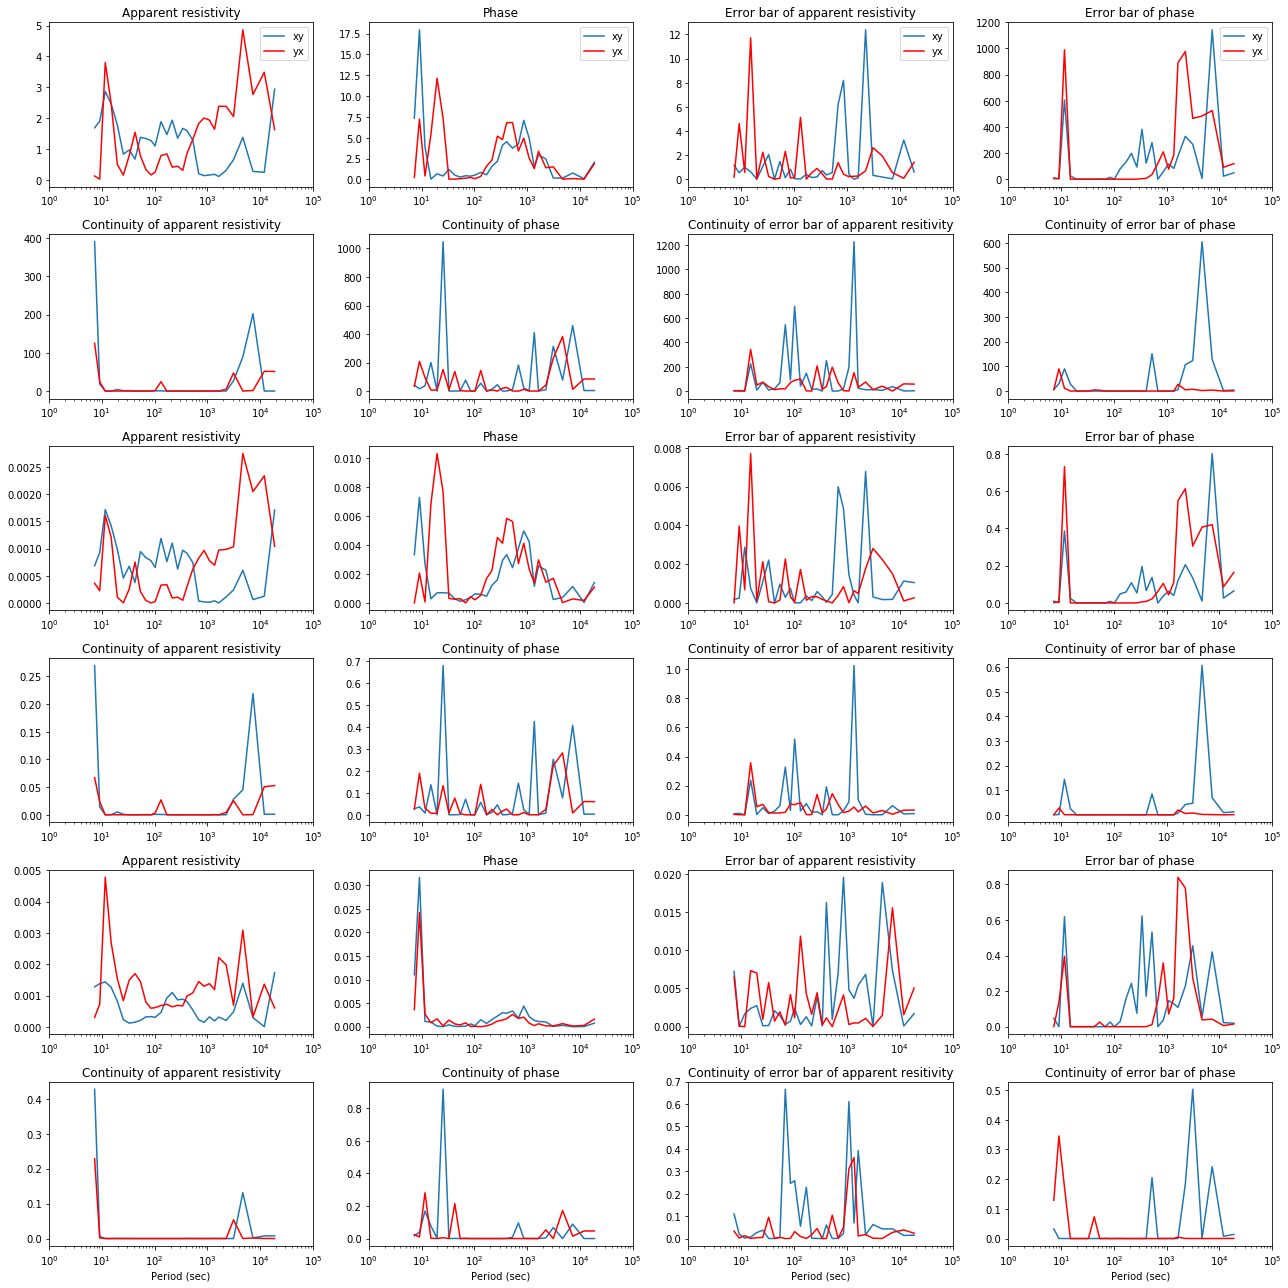

In [34]:
# 
plt.figure(figsize=(18,18))

for n in range(len(site_index)):

# for n in range(1):
    score = rel_score_reshape[n,:,:]
    for i in range(ndata*2):
        if i%2 == 0:
            comp = '(xy)'
        else:
            comp = '(yx)'

        if i == 0:
            title = 'Apparent resistivity'
        elif i == 1:
            title = 'Phase'
        elif i == 2:
            title = 'Error bar of apparent resistivity'
        elif i == 3:
            title = 'Error bar of phase'
        elif i == 4:
            title = 'Continuity of apparent resistivity'
        elif i == 5:
            title = 'Continuity of phase'
        elif i == 6:
            title = 'Continuity of error bar of apparent resitivity'
        elif i == 7:
            title = 'Continuity of error bar of phase'


        plt.subplot(len(site_index)*2,4,i+1+n*8)

        plt.semilogx(period,score[:,0+2*i],label='xy')
        plt.semilogx(period,score[:,1+2*i],label='yx',c='r')
        plt.tight_layout()
        plt.title(title)
        plt.xlim([1.E-0,1.E+5])

#         plt.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#         plt.semilogx(period,rel_score_reshape[0,:,0+2*i],label='xy')
#         plt.semilogx(period,rel_score_reshape[0,:,1+2*i],label='yx')

        if n == 0 and i<4:
            plt.legend()

            
        if n == len(site_index)-1 and i>3:
            plt.xlabel('Period (sec)')

plt.savefig('./sens_analy.eps',format='eps')
plt.show()
